In [1]:
import tensorflow as tf
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split

In [2]:
InputDim  = 32768
OutputDim = 1225
LatentDim = 512
Epochs    = 10
BatchSize = 200
Workers   = os.cpu_count()
Name      = 'ExpansionModel'

In [3]:
Model = tf.keras.Sequential(name=Name)
Model.add(tf.keras.layers.Dense(LatentDim, activation='elu', input_dim=InputDim))
Model.add(tf.keras.layers.Dropout(0.3))
Model.add(tf.keras.layers.Dense(LatentDim, activation='elu'))
Model.add(tf.keras.layers.Dropout(0.1))
Model.add(tf.keras.layers.Dense(LatentDim, activation='elu'))
Model.add(tf.keras.layers.Dropout(0.1))
Model.add(tf.keras.layers.Dense(LatentDim, activation='elu'))
Model.add(tf.keras.layers.Dropout(0.1))
Model.add(tf.keras.layers.Dense(LatentDim, activation='elu'))
Model.add(tf.keras.layers.Dropout(0.1))
Model.add(tf.keras.layers.Dense(LatentDim, activation='elu'))
Model.add(tf.keras.layers.Dropout(0.1))
Model.add(tf.keras.layers.Dense(OutputDim, activation='softmax'))

2022-03-21 13:33:11.509705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 13:33:11.514128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 13:33:11.514279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 13:33:11.514608: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

In [4]:
Model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [5]:
Model.summary()

Model: "ExpansionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)            

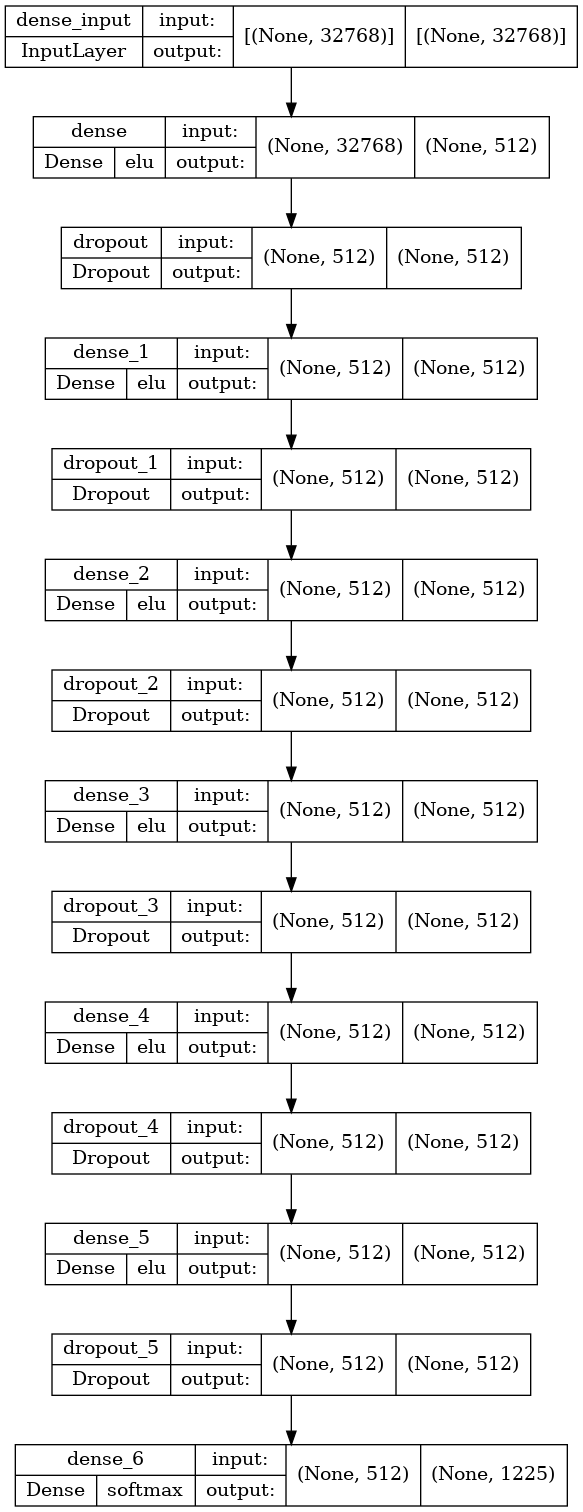

In [6]:
tf.keras.utils.plot_model(Model, show_shapes=True, show_layer_activations=True, to_file='{}.png'.format(Name))

In [7]:
def Fingerprint_to_Array(Mols, Size):
    try:
        FPs  = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(m), radius=2, useChirality=True, nBits=Size) for m in Mols]
        NFPs = [np.zeros((0,)) for i in range(len(Mols))]
        for i, fp in enumerate(FPs):
            Chem.DataStructs.ConvertToNumpyArray(fp, NFPs[i])
    except ValueError:
        NFPs = [np.zeros((Size,)) for i in range(len(Mols))]
    return sum(NFPs)

In [8]:
class Generator(tf.keras.utils.Sequence):

    def __init__(self, Data, Input_Dim=InputDim, Batch_Size=BatchSize, Shuffle=True):
        self.Data       = Data
        self.Num_Data   = len(Data)
        self.Input_Dim  = Input_Dim
        self.Batch_Size = Batch_Size
        self.Shuffle    = Shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(self.Num_Data/self.Batch_Size))

    def __getitem__(self, idx):
        Data_Idx   = self.Data_Idx[self.Batch_Size*idx:self.Batch_Size*(idx+1)]
        Batch_Data = [self.Data[k] for k in Data_Idx]
        X, Y       = self.__Preprocessing_Data(Batch_Data)
        return X, Y

    def __Preprocessing_Data(self, Input_Data):
        X = np.zeros((self.Batch_Size, self.Input_Dim), dtype=np.float64)
        Y = np.zeros((self.Batch_Size), dtype=np.int64)
        for i, data in enumerate(Input_Data):
            X[i] = Fingerprint_to_Array(data['Products'], self.Input_Dim)
            Y[i] = data['Reaction_Label']
        return X, Y

    def on_epoch_end(self):
        self.Data_Idx = np.arange(self.Num_Data)
        if self.Shuffle:
            np.random.shuffle(self.Data_Idx)

In [9]:
class Save_Weights(tf.keras.callbacks.Callback):

    def __init__(self):
        super(Save_Weights, self).__init__()
        self.Best_Weights = None

    def on_train_begin(self, logs=None):
        self.Best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('val_loss')
        if np.less(current, self.Best):
            self.Best = current
            self.Best_Weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        self.model.set_weights(self.Best_Weights)

In [10]:
with open('USPTO_Labeled.json') as File:
    Data = json.load(File)

Training_Data, Validating_Data = train_test_split(Data, test_size=0.2, shuffle=True)

In [11]:
len(Training_Data), len(Validating_Data)

(209276, 52320)

In [12]:
History = Model.fit(Generator(Training_Data), 
                    validation_data=Generator(Validating_Data),
                    epochs=Epochs, use_multiprocessing=True, workers=Workers,
                    callbacks=[Save_Weights()])

Epoch 1/10
  11/1047 [..............................] - ETA: 17s - loss: 6.7335 - accuracy: 0.0518    

2022-03-21 13:33:23.034574: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1047/1047 [==============================] - 107s 100ms/step - loss: 2.3779 - accuracy: 0.4872 - val_loss: 1.5382 - val_accuracy: 0.6086
Epoch 2/10
1047/1047 [==============================] - 108s 101ms/step - loss: 1.3833 - accuracy: 0.6359 - val_loss: 1.4228 - val_accuracy: 0.6359
Epoch 3/10
1047/1047 [==============================] - 107s 100ms/step - loss: 1.1519 - accuracy: 0.6844 - val_loss: 1.4295 - val_accuracy: 0.6546
Epoch 4/10
1047/1047 [==============================] - 112s 105ms/step - loss: 1.0273 - accuracy: 0.7134 - val_loss: 1.4734 - val_accuracy: 0.6562
Epoch 5/10
1047/1047 [==============================] - 111s 103ms/step - loss: 0.9490 - accuracy: 0.7333 - val_loss: 1.5174 - val_accuracy: 0.6691
Epoch 6/10
1047/1047 [==============================] - 116s 108ms/step - loss: 0.8849 - accuracy: 0.7509 - val_loss: 1.5521 - val_accuracy: 0.6715
Epoch 7/10
1047/1047 [==============================] - 117s 108ms/step - loss: 0.8411 - accuracy: 0.7640 - val_loss: 1.575

In [13]:
Loss, Acc = Model.evaluate(Generator(Validating_Data))
print("Model loss %.4f, model accuracy %.4f" %(Loss, Acc))

262/262 [==============================] - 66s 253ms/step - loss: 1.4228 - accuracy: 0.6359
Model loss 1.4228, model accuracy 0.6359


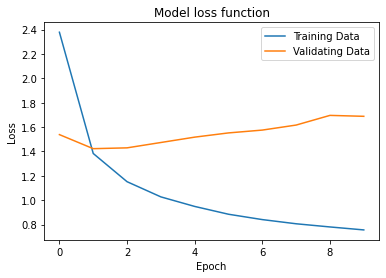

In [14]:
plt.plot(History.epoch, History.history['loss'], History.epoch, History.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Data', 'Validating Data'])
plt.title('Model loss function')
plt.show()

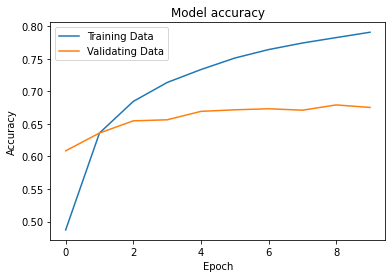

In [18]:
plt.plot(History.epoch, History.history['accuracy'], History.epoch, History.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Data', 'Validating Data'])
plt.title('Model accuracy')
plt.show()

In [16]:
Model.save('{}.h5'.format(Name))